In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os

from statsmodels.tsa.stattools import adfuller
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
import scipy.stats as st
import statsmodels as sm
import scipy.optimize as opt
import scipy

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [4]:
gaz = pd.read_csv(os.path.join("Futures", "Daily_Natural_Gas_Futures_Contract_1.csv"), skiprows=5, parse_dates=['Data'], names=["Data", "Cena gazu [USD/Million Btu]"])
ropa_csv = pd.read_csv(os.path.join("Futures", "Brent_Crude_Oil_Last_Day_BZ=F.csv"))
ropa = pd.DataFrame()

In [5]:
ropa["Data"] = ropa_csv["Date"]
ropa["Cena ropy [USD/Barrel]"] = ropa_csv["Close*"]

In [6]:
ropa = ropa.astype({"Data": "datetime64[ns]"})

In [7]:
df = gaz.merge(ropa, on="Data", how="inner").dropna() # zbiorcza tabela połączona po danych - do analizy dwuwymiarowej
df = df.sort_values(['Data'], ascending=[True])

In [8]:
y_gaz = df['Cena gazu [USD/Million Btu]']
y_ropa = df['Cena ropy [USD/Barrel]']

In [9]:
df['przyrosty_log_gaz'] = np.log(y_gaz).diff().dropna()
df['przyrosty_log_ropa'] = np.log(y_ropa).diff().dropna()

In [16]:
class Portfel:
    """_summary_
    """
    def __init__(self,
                 df,
                 odsetek_ropy:float=.5) -> None:
        self.odsetek_ropy = odsetek_ropy
        self.odsetek_gazu = 1 - odsetek_ropy
        self.usd_na_gaz = np.log(df['Cena gazu [USD/Million Btu]']/6.3).diff().dropna()
        self.usd_na_rope = np.log(df['Cena ropy [USD/Barrel]']).diff().dropna()
    
    @property
    def mean(self):
        return self.odsetek_ropy*self.usd_na_rope.mean() + \
              self.odsetek_gazu*self.usd_na_gaz.mean()
    
    @property
    def var(self):
        return self.odsetek_ropy*self.odsetek_ropy*self.usd_na_rope.var() + \
            self.odsetek_gazu*self.odsetek_gazu*self.usd_na_gaz.var() + \
            2*self.odsetek_gazu*self.odsetek_ropy*self.usd_na_gaz.std()*\
            self.usd_na_rope.std()*np.corrcoef(self.usd_na_gaz[1:],
                                                     self.usd_na_rope[1:])[1,0]
    
    @property
    def corr(self):
        return np.corrcoef(self.usd_na_gaz[1:], self.usd_na_rope[1:])[1,0]

    def quantile(self, q):
        return np.quantile(self.usd_na_rope[1:], q)*self.odsetek_ropy + \
            np.quantile(self.usd_na_gaz[1:], q)*self.odsetek_gazu
    

    def __getitem__(self, key):
        return self.usd_na_rope[1:][key]*self.odsetek_ropy + \
            self.usd_na_gaz[1:][key]*self.odsetek_gazu

In [17]:
space = np.linspace(0, 1, 100)
means = []
vars = []
for i in space:
    p = Portfel(df, odsetek_ropy=i)
    means.append(p.mean)
    vars.append(p.var)

### a)

In [18]:
p = Portfel(df, odsetek_ropy=.8)
portfel_values = [p[i] for i in range(len(df['przyrosty_log_ropa'][1:])-1)]

mean

In [19]:
p.mean

-3.097067272907462e-05

std

In [20]:
np.sqrt(p.var)

0.02189897148559016

corr

In [21]:
p.corr

0.13937114135785103

### b)

Text(0.5, 0, 'Odsetek ropy w portfelu')

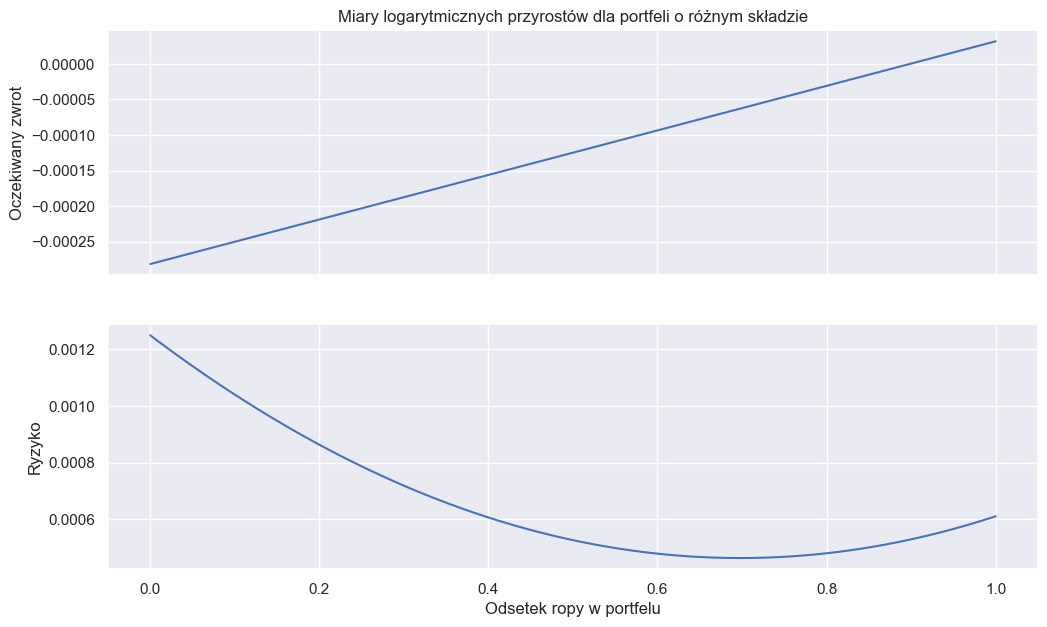

In [13]:
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(space, means)
axs[0].set_ylabel('Oczekiwany zwrot')
axs[0].set_title('Miary logarytmicznych przyrostów dla portfeli o różnym składzie')
axs[1].plot(space, vars)
axs[1].set_ylabel('Ryzyko')
axs[1].set_xlabel('Odsetek ropy w portfelu')